# Домашнее задание №3

ML workflow

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from itertools import product

### Загрузим данные для работы. 

In [2]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Будем решать задачу регрессии: необходимо предсказать качество вина на основе его характеристик

### Шаг 1.  (**0.4 балла**)
Создайте матрицу X объект-признак и целевой вектор y ("quality")

In [3]:
y = df['quality'] # целевая переменная (вектор ответов)
X = df.drop('quality', axis=1) # матрица объект-признак

X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Шаг 2. (**0.4 балла**)
Разбейте данные на train и test (доля тестовых данных - 30%).

In [4]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

### Шаг 3. (**0.4 балла**)
Обучите линейную регрессию на тренировочных данных и сделайте предсказания на train и на test.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(Xtrain, ytrain) # обучение модели


pred_test = model.predict(Xtest) # делаем предсказание
pred_train = model.predict(Xtrain) # сравниваем с train чтобы не было переобучения

### Шаг 4. (**0.8 балла**)
Выведите на экран ошибку MSE на train и на test, затем выведите на экран ошибку r2 на train и test.  

In [6]:
print(f'''{'Train MSE:':<15} {(mean_squared_error(pred_train, ytrain)):.3f}
{'Test MSE:':<15} {(mean_squared_error(pred_test, ytest)):.3f}


{'Train RMSE:':<15} {(mean_squared_error(pred_train, ytrain) ** 0.5):.3f}
{'Test RMSE:':<15} {(mean_squared_error(pred_test, ytest) ** 0.5):.3f}


{'Train R2:':<14} {(r2_score(ytrain, pred_train)):.3f}
{'Test R2:':<14} {(r2_score(ytest, pred_test)):.3f}
''')

Train MSE:      0.413
Test MSE:       0.428


Train RMSE:     0.643
Test RMSE:      0.654


Train R2:      0.352
Test R2:       0.374



In [7]:
# табличка с коэффициентами. Видим, что density имеет оооочень значимый коэффициент
# В целом, и chlorides на фоне остальных признаков имеет боьлшой вес.
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
coefficients

,0,0
0,fixed acidity,0.010990
1,volatile acidity,-1.109611
2,citric acid,-0.234905
3,residual sugar,0.006103
4,chlorides,-2.125363
5,free sulfur dioxide,0.004938
6,total sulfur dioxide,-0.003737
7,density,-5.246459
8,pH,-0.592722
9,sulphates,0.880419


### Шаг 5. (**1 балл**)
Вычислите среднее качество (r2) модели на кросс-валидации с k=5 фолдами.

In [8]:
# На кросс-валидации результаты по r2 гораздо лучше. Почему так?

from sklearn.model_selection import cross_val_score

print(cross_val_score(LinearRegression(), X, y, cv=5, 
                       scoring='r2').mean())

0.29004162884219703


### Шаг 6.  (**1 балл**)
Теперь примените линейную регрессию с L1-регуляризацией (Lasso) для данной задачи. Объявите модель и подберите параметр регуляризации alpha по сетке. Ищите alpha в диапазоне (0.1, 1.1) с шагом 0.1. 

Осуществите подбор параметра alpha по тренировочным данным (Xtrain, ytrain).

In [9]:
# Только у GridSearchCV нашла методы best_esimator_ 
# и Best_score_. Но это кросс-валидация. Хорошо ли на кросс-валидации
# подбирать параметры по Xtrain, ytrain? по идее, там никакой разбивки на tran и test не должно быть
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': (np.arange(0.1, 1.1, 0.1))}

lasso = Lasso()
gridlasso = GridSearchCV(lasso, parameters, cv=5, scoring='r2')
gridlasso.fit(Xtrain, ytrain);


# Возможен еще такой вариант, но тут встроенного удобного метода best_estimator_ нет, придется самим сравнивать r2)
# for a in np.arange(0.1, 1.1, 0.1):
#     model2 = Lasso(alpha=a)
#     model2.fit(Xtrain, ytrain)
# 
#     ypred2 = model2.predict(Xtest)
# 
#     print('alpha={}'.format(a))
#     print(f'R2 test: {r2_score(ytest,ypred2):.3f}, MSE test: {mean_squared_error(ytest,ypred2):.3f}')
#     print(*zip(X.columns, model2.coef_), sep='\n', end='\n\n')

### Шаг 7.  (**1 балл**)
Выведите наилучший алгоритм и наилучшее качество по результатам подбора alpha (best_estimator_ и best_score_).

In [10]:
print("Best alpha parameter:", gridlasso.best_estimator_.alpha)
print(f"Lasso best r2 score: {gridlasso.best_score_:.3f}")
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(gridlasso.best_estimator_.coef_))], axis = 1)
coefficients
# Лассо занулил 7 из 11 признаков (и почти занулил еще 2)
# размерность заметно снизилась

Best alpha parameter: 0.1
Lasso best r2 score: 0.216


,0,0
0,fixed acidity,0.032044
1,volatile acidity,-0.000000
2,citric acid,0.000000
3,residual sugar,0.000000
4,chlorides,-0.000000
5,free sulfur dioxide,0.006368
6,total sulfur dioxide,-0.004040
7,density,-0.000000
8,pH,-0.000000
9,sulphates,0.000000


### Шаг 8.  (**1 балл**)

С помощью найденного best_estimator_ сделайте предсказание на тестовых данных и выведите на экран r2-score на тесте.

In [11]:
print(f"Lasso test score: {gridlasso.score(Xtest, ytest):.3f}")

Lasso test score: 0.249


### Шаг 9.  (**1 балл**)

Попробуем улучшить качество модели за счет добавления полиномиальных признаков. Создайте pipeline, состоящий из добавления полиномиальных признаков степени 2, а затем применения линейной регрессии.

Затем вычислите r2-score этой модели на кросс валидации с пятью фолдами.

In [12]:
from sklearn.preprocessing import PolynomialFeatures


pipe = Pipeline([
    ('pf', PolynomialFeatures(2)),
    ('model_', LinearRegression())
    ])

round(cross_val_score(pipe, X, y, cv=5, scoring='r2').mean(), 3)

0.23

### Шаг 10.  (**1 балл**)
Обучите модель (pipeline) на тренировочных данных и сделайте предсказания для train и test, затем выведите на экран r2-score и MSE на тренировочных и на тестовых данных.

In [14]:
pipe.fit(Xtrain, ytrain)
ypred = pipe.predict(Xtest)
ytrain_pred = pipe.predict(Xtrain)

# r2_score(y_true, y_pred)

print(f'''r2 на тесте, с полином. признаками: {r2_score(ytest, ypred):.3f} 
MSE на тесте, с полином. признаками: {mean_squared_error(ytest, ypred):.3f}

r2 на train, с полином. признаками: {r2_score(ytrain, ytrain_pred):.3f}
MSE на train, с полином. признаками: {mean_squared_error(ytrain, ytrain_pred):.3f}''')





r2 на тесте, с полином. признаками: 0.337 
MSE на тесте, с полином. признаками: 0.454

r2 на train, с полином. признаками: 0.437
MSE на train, с полином. признаками: 0.359


### Сделайте выводы. Для этого ответьте на вопросы: (**2 балла**)

1) Хорошее ли качество показала исходная модель (линейная регрессия без регуляризации)? Является ли эта модель переобученной?

2) Помогла ли L1-регуляризация улучшить качество модели?

3) Помогло ли добавление полиномов второй степени улучшить качество модели? Как добавление новых признаков повлияло на переобучение?

1) Исходная модель показала плохое качество. Удивительно, что результат на кросс-валидаци (0.29) так сильно отличается от результата на train-test предсказаниях: -0.736 и -0.7 соответственно. Хотя разница между train и test невелика, огромный отрицательный коэффициент density (-34) показывает, что модель переобучена и учитывает, грубо говоря, только его.

2) L1-регуляризация заметно уменьшила размерность, пресловутый density занулился. Мы видим, что на кросс-валидации кач-во стало хуже (0.23 против 0.29 без L1-регуляризации), хотя эта оценка грубая, ведь в GridSearchCV мы учитывали только train-данные. Когда мы проверяли кач-во на тестовых данных с Лассо, результат стал 0.243 (против -0.7 без Лассо-регуляризации). Можем сказать, что качетсво предсказания тестовых данных мы получим заметно лучше.

3) Добавление полиномиальных признаков заметно улучшило кач-во, но мы видим, как увеличился разрыв между r2 train и test: 0.455 на обучающих данных, 0.309 на тестовых. Это признак переобучения. Посмотрим на коэффициенты модели с добавлением полиномов. Мы сильно увеличили размерность (if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].), след., при degree=2 увеличили кол-во признаков в 7 раз! Кросс-валидация на модели с полиномом хуже, 0.23 против 0.29

In [15]:
# Коэффициенты есть очень значимые. Например, #8
list(enumerate(pipe.named_steps['model_'].coef_))

[(0, -0.00012842728282479803),
 (1, -41.60136750312666),
 (2, -8.277677788153635),
 (3, -371.4055400734172),
 (4, 28.34531809420213),
 (5, -606.8343940284415),
 (6, -10.211701132500222),
 (7, 3.1906752533494065),
 (8, -22517.812830461407),
 (9, -595.4684089881215),
 (10, 417.3970656817401),
 (11, 27.667090732762674),
 (12, -0.04412152971599426),
 (13, -0.18594197839428261),
 (14, -0.2520188790355178),
 (15, -0.007523519395135736),
 (16, -1.7148705968626956),
 (17, -0.00574694216561511),
 (18, 0.0012084893769497285),
 (19, 43.79977545434127),
 (20, -0.49263509117901094),
 (21, 0.10835835248396464),
 (22, 0.061878399329543754),
 (23, -0.17522407172544963),
 (24, 0.690698590604164),
 (25, -0.14548440340480795),
 (26, -2.0115016092856592),
 (27, -0.02004754155987598),
 (28, 0.018029052503834464),
 (29, 13.349408651054873),
 (30, -1.8868826314021447),
 (31, 0.5681517145760702),
 (32, 0.14068881957165047),
 (33, -0.7649840557859022),
 (34, 0.011579522579950208),
 (35, 6.9834011083286915),
 (

### *Попытайтесь улучшить модель (добейтесь наилучшего качества) - можно использовать любые методы.

При улучшении качества r2 на 0.1-0.2 +1 балл, при большем улучшении +2 балла (дополнительно к 10 баллам за основную часть).

In [16]:
# Мы уверены, что это задача регрессии?
# Если мы посмотрим на значения целевой переменной, мы увидим, что они дискретны

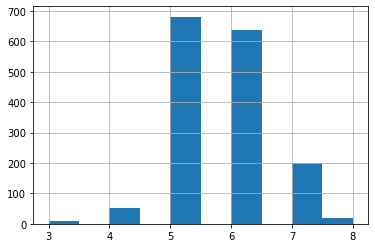

In [19]:
y.hist();

In [20]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [21]:
# Но по условию мы должны улучшить r2, значит, решаем задачу регрессии
# Попробуем L2-регуляризацию, чтобы признаки не занулялись, а уменьшились и выровнялись
from sklearn.linear_model import RidgeCV

ridge_alphas = [1e-3, 1e-2, 1e-1, 1]
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='r2',
                   cv=5)
ridge_cv.fit(X, y)

ridge_cv.score(X, y)

0.3602671048905176

In [22]:
# L2-регуляризация выровняла коэффициенты. Кросс-валидация улучшилась
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(ridge_cv.coef_))], axis = 1)
coefficients

,0,0
0,fixed acidity,0.009056
1,volatile acidity,-1.099029
2,citric acid,-0.187014
3,residual sugar,0.008843
4,chlorides,-1.829590
5,free sulfur dioxide,0.004505
6,total sulfur dioxide,-0.003297
7,density,-0.164703
8,pH,-0.494806
9,sulphates,0.883334


In [23]:
# попытки удалить признаки или добавить новые результатов не дали.